## Mutation Mapping:

use mut mapping to identify weak / borderline G4s in gene promoters (maybe in cancer related genes) which the model suggests could be succeptible to mutation which could strengthen / weaken them.

* predict G4s in promoter regions
* produce mutmaps for each promoter G4
* calculate std of mutmap for G4

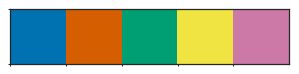

In [48]:
import re
from functools import reduce
from operator import add
import random
import copy
from collections import defaultdict
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy.signal import find_peaks_cwt, argrelextrema
from scipy.special import logit
import seaborn as sns
from seaborn.utils import ci as conf_interval, ci_to_errsize
import h5py
from Bio.SeqIO import parse
from pyfaidx import Fasta

from g4seeqer import mutmap as mm
from g4seeqer.neuralnet import one_hot_sequence, decode_ohe, load_model
from vis.utils import utils as vis_utils

sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
model = load_model()
from vis.utils.utils import apply_modifications
from keras.activations import linear

model.layers[-1].activation = linear
model_linear_output = apply_modifications(model)

In [43]:
howlong2long = pd.read_html('https://academic.oup.com/view-large/82651977/'
                            'How%20long%20is%20too%20long?%20Effects%20of%'
                            '20loop%20size%20on%20G-quadruplex%20stability',
                            header=[0, 1])[0]
howlong2long.dropna(axis=1, how='all', inplace=True)
howlong2long.dropna(axis=0, how='any', inplace=True)
howlong2long.columns = ['name', 't1', 'l1', 't2', 'l2', 't3', 'l3', 't4', 'tm_na', 'tm_k']
lcols = ['l1', 'l2', 'l3',]
for c in lcols:
    l = howlong2long[c].str.extract('(\w+)\s*(\d*)')
    l[1] = l[1].replace('', '1').astype(np.int)
    howlong2long[c] = l[0] * l[1]
howlong2long['tm_na'] = howlong2long.tm_na.str.extract('(\d+(\.\d+)*)', expand=True)[0].astype('float')
howlong2long['tm_k'] = howlong2long.tm_k.str.extract('(\d+(\.\d+)*)', expand=True)[0].astype('float')
howlong2long['seq'] = reduce(add, howlong2long[['t1', 'l1', 't2', 'l2', 't3', 'l3', 't4']].values.T)
for c in lcols:
    howlong2long[c + '_len'] = howlong2long[c].str.len()
howlong2long.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,name,t1,l1,t2,l2,t3,l3,t4,tm_na,tm_k,seq,l1_len,l2_len,l3_len
1,( 16 ) 121,GGG,T,GGG,TT,GGG,T,GGG,51.0,84.0,GGGTGGGTTGGGTGGG,1,2,1
2,(17) 131,GGG,T,GGG,TTT,GGG,T,GGG,45.5,81.8,GGGTGGGTTTGGGTGGG,1,3,1
3,(18) 141,GGG,T,GGG,TTTT,GGG,T,GGG,43.0,76.5,GGGTGGGTTTTGGGTGGG,1,4,1
4,(19) 151,GGG,T,GGG,TTTTT,GGG,T,GGG,41.5,73.5,GGGTGGGTTTTTGGGTGGG,1,5,1
5,(20) 161,GGG,T,GGG,TTTTTT,GGG,T,GGG,40.3,70.5,GGGTGGGTTTTTTGGGTGGG,1,6,1


In [73]:
loop_res = []
for _ in range(1000):
    seq_ohe = np.asarray([
        one_hot_sequence(seq, pad='random') for seq in howlong2long.seq])
    loop_res.append(model_linear_output.predict(seq_ohe).ravel())
loop_res = np.asarray(loop_res)

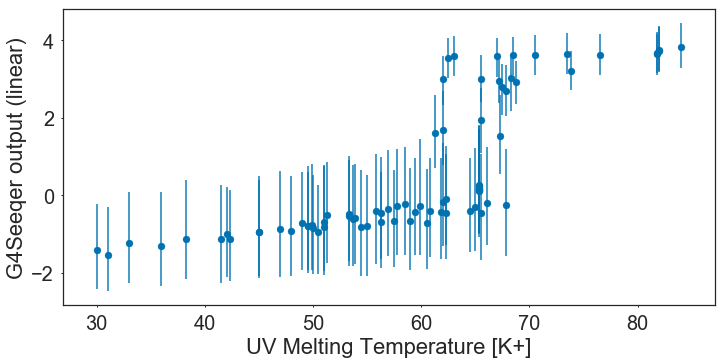

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
med = np.median(loop_res, axis=0)
ci = conf_interval(loop_res, which=68, axis=0)
err = np.abs(med - ci)
ax.errorbar(
    x=howlong2long.tm_k,
    y=med,
    yerr=err,
    linestyle='none',
    color=pal[0],
    alpha=0.8,
    zorder=0)
ax.scatter(
    x=howlong2long.tm_k,
    y=med,
    color=pal[0],
    zorder=1)
ax.set_ylabel('G4Seeqer output (linear)')
ax.set_xlabel('UV Melting Temperature [K+]')
plt.savefig('./figures/tm_vs_g4s_score.svg')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.show()

In [76]:
howlong2long['g4seeqer_pred'] = med
stats.spearmanr(howlong2long.dropna().tm_k, howlong2long.dropna().g4seeqer_pred)

SpearmanrResult(correlation=0.93014517394197882, pvalue=1.1137232361810443e-35)

In [77]:
def random_g4(tetrad_number,
              loop_1_len,
              loop_2_len,
              loop_3_len,
              loop_1_use_g=False,
              loop_2_use_g=False,
              loop_3_use_g=False):
    t = 'G' * tetrad_number
    loop1_choice = 'ACGT' if loop_1_use_g else 'ACT'
    loop2_choice = 'ACGT' if loop_2_use_g else 'ACT'
    loop3_choice = 'ACGT' if loop_3_use_g else 'ACT'
    loop_1 = ''.join(random.choice(list(loop1_choice)) for _ in range(loop_1_len))
    loop_2 = ''.join(random.choice(list(loop2_choice)) for _ in range(loop_2_len))
    loop_3 = ''.join(random.choice(list(loop3_choice)) for _ in range(loop_3_len))
    return t + loop_1 + t + loop_2 + t + loop_3 + t

In [83]:
err

array([[ 0.00702181,  0.01521817,  0.01469047,  0.0317064 ,  0.034542  ,
         0.05114074,  0.04355774,  0.02723351,  0.02512949,  0.06216182,
         0.05434187,  0.06930365,  0.05922522,  0.07601554,  0.10159531,
         0.09711803,  0.07137602,  0.05767813,  0.09555066,  0.10119885,
         0.12506133,  0.09716312,  0.12414365,  0.12288248,  0.11297964,
         0.13947225,  0.09459908,  0.14244342,  0.15200706,  0.12035716,
         0.13046025,  0.13539171,  0.12311413,  0.09735384,  0.12382262,
         0.10892864,  0.14193   ,  0.12023957,  0.13999678,  0.15288115,
         0.13475424,  0.13880902,  0.13074539,  0.12453109,  0.13766686,
         0.19488688,  0.16826247,  0.15001451,  0.14404308,  0.13393435,
         0.16551205,  0.14029578,  0.18596781,  0.17294487,  0.1410433 ,
         0.11895365,  0.13598548,  0.18786586,  0.16019289],
       [ 0.01673331,  0.02395337,  0.02956224,  0.04529598,  0.04138094,
         0.04833289,  0.04448603,  0.05457444,  0.05249568,  0.

1


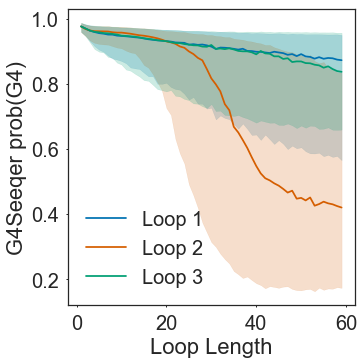

2


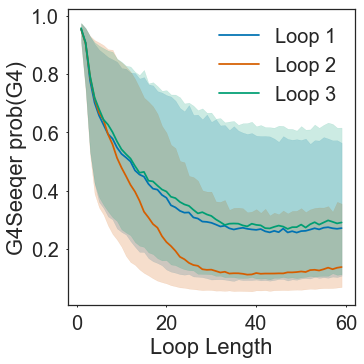

3


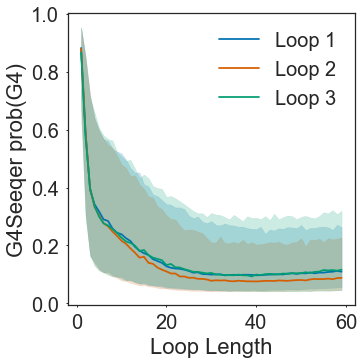

In [87]:
for i in range(1, 4):
    print(i)
    res = defaultdict(list)
    for loop_n, loop_length in it.product(range(3), range(1, 60)):
        seq_ohe = []
        loop_lengths = [i, i, i]
        loop_lengths[loop_n] = loop_length
        for _ in range(5000):
            seq_ohe.append(one_hot_sequence(random_g4(3, *loop_lengths), pad='random')) 
        res[loop_n].append(model.predict(np.asarray(seq_ohe)).ravel())
    res = np.asarray([res[i] for i in range(3)])

    fig, ax = plt.subplots(figsize=(5, 5))
    for j, r in enumerate(res):
        med = np.median(r, axis=1)
        ci = conf_interval(r, which=68, axis=1)
        ax.fill_between(np.arange(1, 60),
                        ci[0],
                        ci[1],
                        color=pal[j],
                        alpha=0.2)
        ax.plot(np.arange(1, 60),
                med,
                color=pal[j],
                label='Loop {}'.format(j + 1))
    ax.set(xlabel='Loop Length', ylabel='G4Seeqer prob(G4)')
    plt.legend()
    plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    plt.savefig('./figures/g4s_score_loop_length_{}.svg'.format(i))
    plt.show()

In [14]:
%%bash
zcat ./data/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20161111.gff.gz | \
sed -n '/Promoter$/p' | \
cut -f1,4-5 | \
sed 's/^/chr/' | \
sort -k1,1 -k4,4n > ./data/hg38_promoters.bed
head ./data/hg38_promoters.bed

chr1	100036800	100040201
chr1	1001200	1002001
chr1	100132000	100134201
chr1	100249000	100250401
chr1	100265400	100267401
chr1	10032400	10035200
chr1	100350801	100354201
chr1	100719600	100722201
chr1	100893800	100897201
chr1	101025000	101027001


In [141]:
%%bash
source activate cgat_python2
bedtools getfasta \
  -fi /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg38_noalt.fa \
  -bed ./data/hg38_promoters.bed \
  -fo ./data/hg38_promoters.fa
samtools faidx ./data/hg38_promoters.fa

WARNING. chromosome (chrGL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270713.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270721.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270721.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270721.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270728.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270734.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270734.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrKI270734.1) was not found in the FASTA file. Skipping.


In [208]:
%%bash
source activate cgat_python2
g4predict intra -tmin 3 -tmax 3 -lmin 1 -lmax 12 -s \
  -f /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -b ./data/quadparser_g4s.bed

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': './data/quadparser_g4s.bed',
        'fasta': '/home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa',
        'filter_overlapping': False,
        'func': <function intra at 0x7f198994bc80>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {       'allow_G': 1, 'start': 1, 'stop': 12},
                                    {       'allow_G': 1, 'start': 1, 'stop': 12},
                                    {       'allow_G': 1, 'start': 1, 'stop': 12}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad

In [209]:
%%bash
source activate cgat_python2
sort -k1,1 -k2,2n ./data/quadparser_g4s.bed | \
bedtools slop -b 50 -i stdin \
  -g ./data/hg19.chrom.sizes > ./data/quadparser_g4s_slop.bed
bedtools map -sorted -a <(awk '$6 == "+"' ./data/quadparser_g4s_slop.bed) \
  -b ./data/GSE63874_Na_K_12_minus.bdg -c 4 -o max > ./data/quadparser_g4s_mm_plus.bed
bedtools map -sorted -a <(awk '$6 == "-"' ./data/quadparser_g4s_slop.bed) \
  -b ./data/GSE63874_Na_K_12_plus.bdg -c 4 -o max  > ./data/quadparser_g4s_mm_minus.bed
cat ./data/quadparser_g4s_mm_plus.bed ./data/quadparser_g4s_mm_minus.bed | \
bedtools slop -b -50 -i stdin -g ./data/hg19.chrom.sizes | \
sort -k1,1 -k2,2n > ./data/quadparser_g4s_mm.bed
head ./data/quadparser_g4s_mm.bed

chr1	10003	10024	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10009	10030	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10015	10036	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10021	10042	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10027	10048	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10033	10054	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10039	10060	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10045	10066	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10051	10072	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2
chr1	10057	10078	3t0b3,3,3l0.67A0.00C0.33T0.00G	46.5	-	47.2


In [148]:
fasta = Fasta(
    '/home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa',
    one_based_attributes=False
)

model = load_model()

with_register = []

with open('./data/quadparser_g4s_mm.bed') as qp_bed:
    for record in qp_bed:
        chrom, start, end, _, n_in_cluster, strand, mm_score = record.split()
        start = int(start)
        end = int(end)
        n_in_cluster = int(n_in_cluster)
        mm_score = float(mm_score) if mm_score != "." else 0
        # if there are overlapping G4s this will confuse things
        if n_in_cluster > 1:
            continue
        else:
            seq = fasta[chrom][start - 1: end + 1]
            if strand == '-':
                seq = seq.reverse.complement
            seq = str(seq).upper()
        register = len(re.findall('GGGG', seq))
        if register >= 4:
            # four tetrad G4 not multi-register three tetrad
            continue
        centre = (start + end) // 2
        seq_slop = fasta[chrom][centre - 64: centre + 64]
        if strand == '-':
            seq_slop = seq_slop.reverse.complement
        with_register.append([chrom, start, end, strand,
                              mm_score, register, seq, seq_slop])

In [149]:
with_register = pd.DataFrame.from_records(
    with_register,
    columns=['chrom', 'start', 'end', 'strand',
             'mm_score', 'register', 'seq', 'seq_slop']
)

with_register['g4s_score'] = model.predict(
    np.asarray([one_hot_sequence(seq) for seq in with_register.seq_slop])
).ravel()

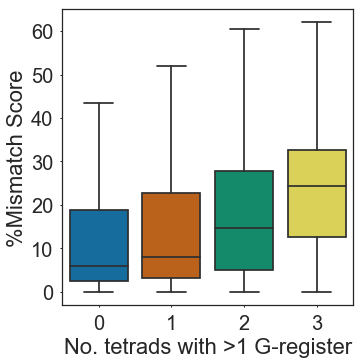

In [157]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='register',
            y='mm_score',
            data=with_register,
            fliersize=0,
            ax=ax)
ax.set_xlabel('No. tetrads with >1 G-register')
ax.set_ylabel('%Mismatch Score')
ax.set_ylim(-3, 65)
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('g4_register_mm_score.svg')
plt.show()

In [74]:
def g_register(tetrad_number,
               g_register_tetrads,
               loop1, loop2, loop3,
               loop1_useg=False,
               loop2_useg=False,
               loop3_useg=False):
    def _random_seq(n, use_g):
        bases = list('ACGT') if use_g else list('ACT')
        return ''.join(random.choice(bases) for _ in range(n))
    t = 'G' * tetrad_number
    loop1 = _random_seq(loop1, loop1_useg)
    if g_register_tetrads[0]:
        loop1 = 'G' + loop1[1:]
    loop2 = _random_seq(loop2, loop2_useg)
    if g_register_tetrads[1]:
        if random.random() < 0.5:
            loop2 = 'G' + loop2[1:]
        else:
            loop1 = loop1[:-1] + 'G'
    loop3 = _random_seq(loop3, loop3_useg)
    if g_register_tetrads[2]:
        if random.random() < 0.5:
            loop3 = 'G' + loop3[1:]
        else:
            loop2 = loop2[:-1] + 'G'
    if g_register_tetrads[3]:
        loop3 = loop3[:-1] + 'G'
    return t + loop1 + t + loop2 + t + loop3 + t

In [140]:
loop = [3, 3, 3]
res_g_register = {}
for t in it.product([False, True], repeat=4):
    idx = ','.join(['4' if x else '3' for x in t])
    seq_ohe = []
    for _ in range(1000):
        seq_ohe.append(one_hot_sequence(g_register(3, t, *loop), pad='random'))
    res_g_register[idx] = model.predict(np.asarray(seq_ohe)).ravel()
res_g_register = pd.DataFrame.from_dict(res_g_register, orient='columns')
res_g_register = res_g_register.stack().reset_index()
res_g_register = res_g_register.iloc[:, [1, 2]]
res_g_register.columns = ['g_register', 'g4seeqer_pred']
res_g_register['g_register_count'] = res_g_register.g_register.str.count('4')
res_g_register = res_g_register[res_g_register['g_register_count'] != 4]

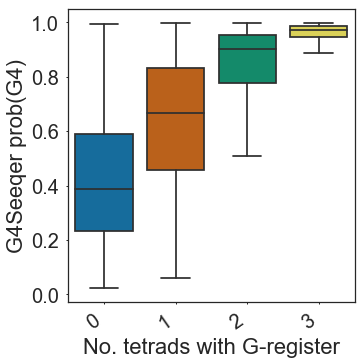

In [145]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.boxplot(x='g_register_count',
                 y='g4seeqer_pred',
                 data=res_g_register,
                 fliersize=0)
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_xlabel('No. tetrads with G-register')
ax.set_ylabel('G4Seeqer prob(G4)')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/G4Seeqer_g4_register.svg')
plt.show()

In [102]:
%%bash --bg
source activate ml_python35
mutmap2h5 -f ./data/hg38_promoters.fa -h ./data/hg38_promoter_g4_mutmaps.h5

Starting job # 0 in a separate thread.


In [149]:
mm_stats = mm.summarise_mutmap_h5('./data/hg38_promoter_g4_mutmaps.h5')
mm_stats.head()

,ref_id,start,end,reverse,seq,actual_score,mean_mut_score,min_mut_score,max_mut_score,mut_score_variance,mut_score_skewness
0,chr1:100036800-100040201,185,313,1,CTTCAGAGGCTAGGTCATAAAAGGCACTGCATCTTCCTTTGCGGGT...,0.049556,0.001180,-0.017807,0.140991,0.000153,7.117333
1,chr1:100036800-100040201,330,458,0,GTTTTGATCTATCAAGAGTCACTAAGCCTAGTCTACACTCAAGGGG...,0.041739,0.005829,-0.024310,0.568152,0.002790,9.519003
2,chr1:100036800-100040201,450,578,1,GGATAGGGATACACCGCATGCTCCCTACTCTCAGATGGTTAGGGAG...,0.050981,0.004392,-0.016819,0.754140,0.002045,13.505049
3,chr1:100036800-100040201,770,898,0,CAGGTAAGGTATTTTTTTTGGCAGGGAATAAAAAAGGTCCTGGGTC...,0.057279,0.002498,-0.018242,0.252910,0.000475,8.045944
4,chr1:100036800-100040201,1110,1238,1,GATACCGCCCCGCCCGCTCGCCGCCAGCCCACTCTACAGTAGCCGC...,0.739931,-0.011923,-0.170440,0.096391,0.001690,-0.772202


In [150]:
invs = mm_stats.ref_id.str.extract('(chr.*):(\d+)-(\d+)', expand=True)
invs[1] = invs[1].astype('i')
mm_stats['ref_id'] = invs[0]
mm_stats['start'] = (mm_stats.start + invs[1]).astype('i')
mm_stats['end'] = (mm_stats.end + invs[1]).astype('i')
mm_stats.head()

,ref_id,start,end,reverse,seq,actual_score,mean_mut_score,min_mut_score,max_mut_score,mut_score_variance,mut_score_skewness
0,chr1,100036985,100037113,1,CTTCAGAGGCTAGGTCATAAAAGGCACTGCATCTTCCTTTGCGGGT...,0.049556,0.001180,-0.017807,0.140991,0.000153,7.117333
1,chr1,100037130,100037258,0,GTTTTGATCTATCAAGAGTCACTAAGCCTAGTCTACACTCAAGGGG...,0.041739,0.005829,-0.024310,0.568152,0.002790,9.519003
2,chr1,100037250,100037378,1,GGATAGGGATACACCGCATGCTCCCTACTCTCAGATGGTTAGGGAG...,0.050981,0.004392,-0.016819,0.754140,0.002045,13.505049
3,chr1,100037570,100037698,0,CAGGTAAGGTATTTTTTTTGGCAGGGAATAAAAAAGGTCCTGGGTC...,0.057279,0.002498,-0.018242,0.252910,0.000475,8.045944
4,chr1,100037910,100038038,1,GATACCGCCCCGCCCGCTCGCCGCCAGCCCACTCTACAGTAGCCGC...,0.739931,-0.011923,-0.170440,0.096391,0.001690,-0.772202


In [151]:
def get_mutmap_for_index(idx, h5_fn):
    with h5py.File(h5_fn) as h5_file:
        seq_ohe = h5_file['seq'].value[idx]
        mm_scores = h5_file['mutmaps'].value[idx]
    return mm.mutmap_scores_to_heatmap(seq_ohe, mm_scores)

In [152]:
mm_stats[
    mm_stats.seq.str.contains('(GGG[ACGT]{1,4}){2}GGG')
].sort_values('min_mut_score').head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


,ref_id,start,end,reverse,seq,actual_score,mean_mut_score,min_mut_score,max_mut_score,mut_score_variance,mut_score_skewness
123123,chr3,101575400,101575528,1,TTTAAATTGTTCTTTCATAAGGTATTTTACTAGTTATAAAAAAAAA...,0.992723,-0.027765,-0.963476,0.003810,0.020367,-5.751314
55015,chr14,96503865,96503993,1,TAGTTAGTTAAGTCTAACAAACGTTTTCATCACAGAAGTAATGTGA...,0.985958,-0.032037,-0.962923,0.009668,0.023133,-5.495156
38421,chr12,121802505,121802633,1,TAAGTAAATGACATATTTTTTTTCCTCTTTTTGTTCTATGGGTGGG...,0.991652,-0.027574,-0.962736,0.002261,0.020914,-5.978097
126736,chr3,170179880,170180008,1,GTTTTTTCATGGAATAGAAAGTGTTCTTACATTTTTATCAGTGCTG...,0.982972,-0.034436,-0.957184,0.010963,0.024226,-5.170677
23561,chr10,63268265,63268393,0,AAAGAACAAAGTCCAAATTCCCACCCAAGCAGGTCTATTGAAAAAC...,0.977774,-0.042524,-0.956076,0.009538,0.033374,-4.510753


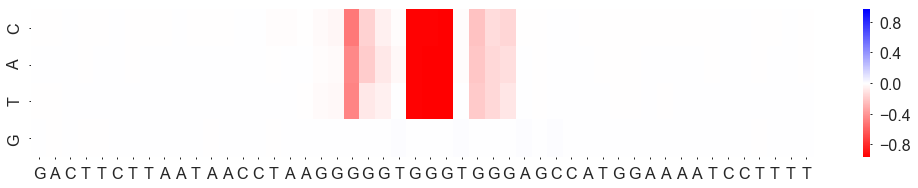

In [169]:
score, mutmap = get_mutmap_for_index(55015, './data/hg38_promoter_g4_mutmaps.h5')
mutmap_crop = mutmap.iloc[:, 48:-30]
sns.set(style=style, font_scale=1.6)
fig, ax = mm.plot_mutation_map(score, mutmap_crop)
ax.set_title('')
plt.tight_layout()
plt.savefig('./figures/g_triplex_mutmap.svg')
plt.show()

In [170]:
mm_stats[
    ~mm_stats.seq.str.contains('(GGG[ACGT]{1,4}){2}GGG')
].sort_values('min_mut_score').head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


,ref_id,start,end,reverse,seq,actual_score,mean_mut_score,min_mut_score,max_mut_score,mut_score_variance,mut_score_skewness
100554,chr2,147846370,147846498,1,ATTTATTAACCACAAGGAAATGTACCATTCAGCAAAATTCTATACA...,0.989906,-0.044547,-0.971840,0.004388,0.035249,-4.344280
188681,chrX,56729016,56729144,0,ACTTGAATTTCTTCTCATCTTAAAATTGCATAAATTATATTAAATT...,0.985960,-0.045484,-0.970350,0.008884,0.035935,-4.336482
51208,chr14,32078550,32078678,0,GTAAAACAGCAAAATGCTTCGCTGTATTTACTAGTACTTGCTTATG...,0.992786,-0.045487,-0.964190,0.002628,0.036240,-4.291821
99329,chr2,112543665,112543793,0,CTCTATTCGGCAAATAATATGGGAGCCATTAAGATTTATTGTTTAG...,0.981278,-0.047065,-0.961928,0.006293,0.038172,-4.219552
970,chr1,112397350,112397478,1,GATCGTAAAACCAATCAAAATATACATGAATGTTTCCTGGGGGCGG...,0.984722,-0.050702,-0.961660,0.007805,0.039142,-4.102837


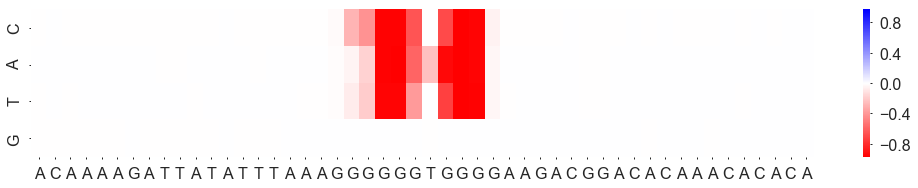

In [172]:
score, mutmap = get_mutmap_for_index(100554, './data/hg38_promoter_g4_mutmaps.h5')
mutmap_crop = mutmap.iloc[:, 48:-30]
sns.set(style=style, font_scale=1.6)
fig, ax = mm.plot_mutation_map(score, mutmap_crop)
ax.set_title('')
plt.tight_layout()
plt.savefig('./figures/g_hairpin_mutmap.svg')
plt.show()

In [47]:
%%bash
source activate cgat_python2
g4predict inter -M -tmin 3 -tmax 6 -lmin 1 -lmax 4 -rmin 3 -rmax 3 -s \
  -f ~/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -b ./data/hg19_g_triplexes.bed

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: inter
INFO:root:Parameters:
{       'bed': './data/hg19_g_triplexes.bed',
        'fasta': '/home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa',
        'filter_overlapping': False,
        'func': <function inter at 0x7f00fa915848>,
        'merge_overlapping': True,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 3, 'stop': 3},
        'loop_kwargs_list': [       {       'allow_G': 1, 'start': 1, 'stop': 4},
                                    {       'allow_G': 1, 'start': 1, 'stop': 4}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor': 20},
        'soft_mask': False,
        'tetrad_kwargs': {       's

In [48]:
%%bash
source activate cgat_python2
bedtools intersect -v \
  -a ./data/hg19_g_triplexes.bed \
  -b ./data/quadparser_g4s.bed \
> ./data/hg19_g_triplexes_filt.bed
head ./data/hg19_g_triplexes_filt.bed

chr1	14664	14677	PG4_cluster	1	+
chr1	15239	15255	PG4_cluster	2	+
chr1	17218	17230	PG4_cluster	1	-
chr1	21577	21592	PG4_cluster	1	-
chr1	21898	21911	PG4_cluster	1	-
chr1	35021	35038	PG4_cluster	1	+
chr1	36080	36097	PG4_cluster	1	+
chr1	72362	72377	PG4_cluster	1	-
chr1	88508	88525	PG4_cluster	1	-
chr1	91465	91480	PG4_cluster	1	+


In [49]:
%%bash
source activate cgat_python2
g4predict inter -M -tmin 4 -tmax 6 -lmin 1 -lmax 4 -rmin 2 -rmax 2 -s \
  -f ~/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -b ./data/hg19_g_hairpins.bed

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: inter
INFO:root:Parameters:
{       'bed': './data/hg19_g_hairpins.bed',
        'fasta': '/home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa',
        'filter_overlapping': False,
        'func': <function inter at 0x7f1b8d046848>,
        'merge_overlapping': True,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 2, 'stop': 2},
        'loop_kwargs_list': [{       'allow_G': 1, 'start': 1, 'stop': 4}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor': 20},
        'soft_mask': False,
        'tetrad_kwargs': {       'start': 4, 'stop': 6}}
INFO:root:Predicting G4s
INFO:root:Predicted 1309868 G4s
INFO:root:S

In [50]:
%%bash
source activate cgat_python2
bedtools intersect -v -sorted \
  -a ./data/hg19_g_hairpins.bed \
  -b <(cat ./data/quadparser_g4s.bed ./data/hg19_g_triplexes.bed | sort -k1,1 -k2,2n) \
> ./data/hg19_g_hairpins_filt.bed
head ./data/hg19_g_hairpins_filt.bed

chr1	14517	14526	PG4_cluster	1	-
chr1	14876	14888	PG4_cluster	3	-
chr1	16725	16739	PG4_cluster	2	+
chr1	16912	16924	PG4_cluster	1	+
chr1	18251	18262	PG4_cluster	1	+
chr1	20737	20746	PG4_cluster	1	-
chr1	21046	21056	PG4_cluster	1	-
chr1	22100	22111	PG4_cluster	1	-
chr1	24030	24042	PG4_cluster	1	-
chr1	25019	25031	PG4_cluster	1	+


In [51]:
%%bash
source activate cgat_python2
sort -k1,1 -k2,2n ./data/hg19_g_triplexes_filt.bed | \
bedtools slop -b 50 -i stdin \
  -g ./data/hg19.chrom.sizes > ./data/hg19_g_triplexes_slop.bed
bedtools map -a <(awk '$6 == "+"' ./data/hg19_g_triplexes_slop.bed) \
  -b ./data/GSE63874_Na_K_12_minus.bdg -c 4 -o max | \
awk -v OFS='\t' '$7 != "."{print $1, $2, $3, $5, $7, $6}' > ./data/hg19_g_triplexes_mm_plus.bed
bedtools map -a <(awk '$6 == "-"' ./data/hg19_g_triplexes_slop.bed) \
  -b ./data/GSE63874_Na_K_12_plus.bdg -c 4 -o max | \
awk -v OFS='\t' '$7 != "."{print $1, $2, $3, $5, $7, $6}' > ./data/hg19_g_triplexes_mm_minus.bed
cat ./data/hg19_g_triplexes_mm_plus.bed ./data/hg19_g_triplexes_mm_minus.bed | \
bedtools slop -b -50 -i stdin -g ./data/hg19.chrom.sizes | \
sort -k1,1 -k2,2n > ./data/hg19_g_triplexes_mm.bed
head ./data/hg19_g_triplexes_mm.bed

chr1	14664	14677	1	2	+
chr1	15239	15255	2	2	+
chr1	17218	17230	1	17.3	-
chr1	21577	21592	1	30.9	-
chr1	21898	21911	1	28.7	-
chr1	72362	72377	1	2.4	-
chr1	88508	88525	1	2.4	-
chr1	91465	91480	1	17.4	+
chr1	96398	96411	1	1.1	+
chr1	136008	136025	1	3.5	-


In [52]:
%%bash
source activate cgat_python2
sort -k1,1 -k2,2n ./data/hg19_g_hairpins_filt.bed | \
bedtools slop -b 50 -i stdin \
  -g ./data/hg19.chrom.sizes > ./data/hg19_g_hairpins_slop.bed
bedtools map -a <(awk '$6 == "+"' ./data/hg19_g_hairpins_slop.bed) \
  -b ./data/GSE63874_Na_K_12_minus.bdg -c 4 -o max | \
awk -v OFS='\t' '$7 != "."{print $1, $2, $3, $5, $7, $6}' > ./data/hg19_g_hairpins_mm_plus.bed
bedtools map -a <(awk '$6 == "-"' ./data/hg19_g_hairpins_slop.bed) \
  -b ./data/GSE63874_Na_K_12_plus.bdg -c 4 -o max | \
awk -v OFS='\t' '$7 != "."{print $1, $2, $3, $5, $7, $6}' > ./data/hg19_g_hairpins_mm_minus.bed
cat ./data/hg19_g_hairpins_mm_plus.bed ./data/hg19_g_hairpins_mm_minus.bed | \
bedtools slop -b -50 -i stdin -g ./data/hg19.chrom.sizes | \
sort -k1,1 -k2,2n > ./data/hg19_g_hairpins_mm.bed
head ./data/hg19_g_hairpins_mm.bed

chr1	14517	14526	1	16.9	-
chr1	14876	14888	3	11.2	-
chr1	16725	16739	2	27.8	+
chr1	16912	16924	1	8.1	+
chr1	20737	20746	1	15.9	-
chr1	21046	21056	1	5.8	-
chr1	22100	22111	1	6.7	-
chr1	24030	24042	1	1.8	-
chr1	29385	29397	1	27.8	-
chr1	30809	30818	1	9.3	+


In [24]:
elbow = 3.0332550345428047

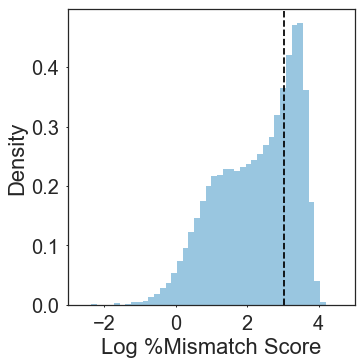

In [152]:
g_triplexes = pd.read_csv('./data/hg19_g_triplexes_mm.bed',
                          sep='\t',
                          names=['chrom', 'start', 'end', 's', 'mm_score', 'strand'],
                          usecols=['chrom', 'start', 'end', 'mm_score', 'strand'])
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.distplot(
    np.log(g_triplexes.mm_score) + np.random.normal(0, 0.05, size=len(g_triplexes)),
    kde=False,
    hist_kws={'range': (-3, 5), 'normed': True},
    ax=ax
)
ax.axvline(elbow, ls='--', color='k')
ax.set_xlabel('Log %Mismatch Score')
ax.set_ylabel('Density')
ax.set_xlim(-3, 5)
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/g_triplex_mm_score_hist.svg')
plt.show()

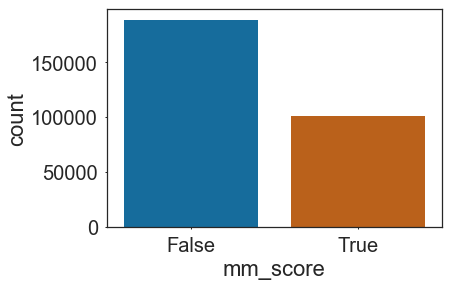

In [134]:
sns.countplot(g_triplexes.mm_score > np.exp(2.98))
plt.show()

In [135]:
(g_triplexes.mm_score > np.exp(2.98)).sum() / g_triplexes.shape[0]

0.34947501903852846

In [32]:
fasta = Fasta(
    '/home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa',
    one_based_attributes=False)


def get_nearest_g_runs_left(inv, max_search=500):
    left = max(inv.start - max_search, 0)
    right = inv.start
    seq_rec = fasta[inv.chrom][left: right]
    if inv.strand == '-':
        seq_rec = seq_rec.complement
    seq = seq_rec.seq[::-1]
    match = re.search('GGG', seq)
    if match:
        return match.start()
    else:
        return max_search

def get_nearest_g_runs_right(inv, max_search=500):
    left = inv.end
    right = inv.end + max_search
    seq_rec = fasta[inv.chrom][left: right]
    if inv.strand == '-':
        seq_rec = seq_rec.complement
    seq = seq_rec.seq
    match = re.search('GGG', seq)
    if match:
        return match.start()
    else:
        return max_search


g_triplexes['left_nearest_g_run'] = g_triplexes.apply(get_nearest_g_runs_left, axis=1)
g_triplexes['right_nearest_g_run'] = g_triplexes.apply(get_nearest_g_runs_right, axis=1)
g_triplexes['nearest_g_run_abs'] = g_triplexes[
    ['left_nearest_g_run', 'right_nearest_g_run']].min(axis=1)
g_triplexes = g_triplexes[g_triplexes.nearest_g_run_abs != 0]

In [33]:
g_triplexes['5prime_nearest_g_run'] = [
    g.left_nearest_g_run if g.strand == '+' else g.right_nearest_g_run
    for _, g in g_triplexes.iterrows()]
g_triplexes['3prime_nearest_g_run'] = [
    g.right_nearest_g_run if g.strand == '+' else g.left_nearest_g_run
    for _, g in g_triplexes.iterrows()]

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


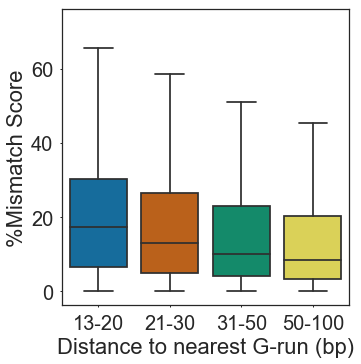

In [151]:
fig, ax = plt.subplots(figsize=(5, 5))
g_triplexes['nearest_g_run_cut'] = pd.cut(
    g_triplexes['nearest_g_run_abs'],
    bins=(13, 20, 30, 50, 100),
    labels=['13-20', '21-30', '31-50', '50-100']
)
sns.boxplot(x='nearest_g_run_cut',
            y='mm_score',
            data=g_triplexes,
            fliersize=0)
ax.set_ylabel('%Mismatch Score')
ax.set_xlabel('Distance to nearest G-run (bp)')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/g_triplex_mm_score_boxplot.svg')
plt.show()


In [48]:
g = g_triplexes[g_triplexes['nearest_g_run_abs'] < 101]
print(stats.spearmanr(g['nearest_g_run_abs'], g.mm_score))
print(stats.spearmanr(g['5prime_nearest_g_run'], g.mm_score))
print(stats.spearmanr(g['3prime_nearest_g_run'], g.mm_score))

SpearmanrResult(correlation=-0.2042397064786281, pvalue=0.0)
SpearmanrResult(correlation=-0.16710291967657695, pvalue=0.0)
SpearmanrResult(correlation=-0.15322782184724068, pvalue=0.0)


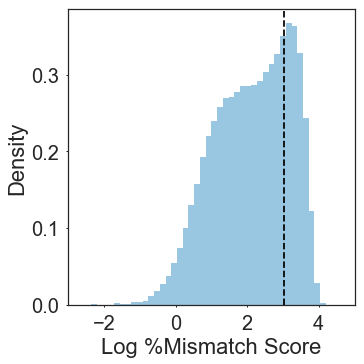

In [124]:
g_hairpins = pd.read_csv('./data/hg19_g_hairpins_mm.bed',
                         sep='\t',
                         names=['chrom', 'start', 'end', 's', 'mm_score', 'strand'],
                         usecols=['chrom', 'start', 'end', 'mm_score', 'strand'])
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.distplot(
    np.log(g_hairpins.mm_score) + np.random.normal(0, 0.05, size=len(g_hairpins)),
    kde=False,
    hist_kws={'range': (-3, 5), 'normed': True},
    ax=ax
)
ax.set_xlim(-3, 5)
ax.axvline(elbow, ls='--', color='k')
ax.set_xlabel('Log %Mismatch Score')
ax.set_ylabel('Density')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/g_hairpin_mm_score_hist.svg')
plt.show()

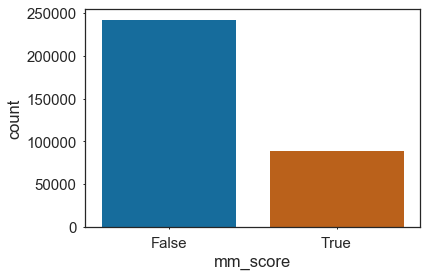

In [58]:
sns.countplot(g_hairpins.mm_score > np.exp(2.98))
plt.show()

In [59]:
(g_hairpins.mm_score > np.exp(2.98)).sum() / g_hairpins.shape[0]

0.26888308709234415

In [61]:
%%bash
source activate cgat_python2
bedtools closest -io -s -d \
  -a ./data/hg19_g_hairpins_mm.bed \
  -b ./data/hg19_g_hairpins_mm.bed > ./data/hg19_g_hairpins_mm_closest.bed
head ./data/hg19_g_hairpins_mm_closest.bed

chr1	14517	14526	1	16.9	-	chr1	14876	14888	3	11.2	-	351
chr1	14876	14888	3	11.2	-	chr1	14517	14526	1	16.9	-	351
chr1	16725	16739	2	27.8	+	chr1	16912	16924	1	8.1	+	174
chr1	16912	16924	1	8.1	+	chr1	16725	16739	2	27.8	+	174
chr1	20737	20746	1	15.9	-	chr1	21046	21056	1	5.8	-	301
chr1	21046	21056	1	5.8	-	chr1	20737	20746	1	15.9	-	301
chr1	22100	22111	1	6.7	-	chr1	21046	21056	1	5.8	-	1045
chr1	24030	24042	1	1.8	-	chr1	22100	22111	1	6.7	-	1920
chr1	29385	29397	1	27.8	-	chr1	24030	24042	1	1.8	-	5344
chr1	30809	30818	1	9.3	+	chr1	16912	16924	1	8.1	+	13886


In [121]:
g_hairpins_dist = pd.read_csv(
    './data/hg19_g_hairpins_mm_closest.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 's', 'mm_score', 'strand',
    'chrom2', 'nearest_start', 'nearest_end', 's2', 'mm_score2', 'strand2', 'distance'],
    usecols=['chrom', 'start', 'end', 'mm_score', 'strand', 'distance']
)
g_hairpins_dist['dist_cut'] = pd.cut(
    g_hairpins_dist.distance,
    (13, 50, 100, 200, np.inf),
    labels=['13-50', '51-100', '101-200', '201+']
)

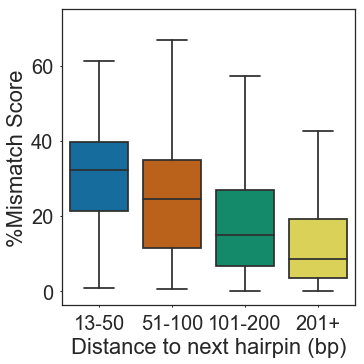

In [125]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='dist_cut', y='mm_score', data=g_hairpins_dist, fliersize=0, ax=ax)
ax.set_xlabel('Distance to next hairpin (bp)')
ax.set_ylabel('%Mismatch Score')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/g_hairpin_mm_score_boxplot.svg')
plt.show()

In [71]:
stats.spearmanr(g_hairpins_dist.distance, g_hairpins_dist.mm_score)

SpearmanrResult(correlation=-0.18029592906448547, pvalue=0.0)

In [31]:
def generate_nucl_freq(n, freqs):
    bases = np.random.choice(['A', 'C', 'T'], size=n, p=freqs)
    return ''.join(bases)

def random_g4_base_freqs(tetrad_number, loop_1_len, loop_2_len,
                         loop_3_len, base_freqs):
    t = 'G' * tetrad_number
    loop_1 = generate_nucl_freq(loop_1_len, base_freqs)
    loop_2 = generate_nucl_freq(loop_2_len, base_freqs)
    loop_3 = generate_nucl_freq(loop_3_len, base_freqs)
    return t + loop_1 + t + loop_2 + t + loop_3 + t

In [34]:
base_freq_scores = np.empty((20, 3))
base_freq_std = np.empty((20, 3))
for i, f in enumerate(np.linspace(0, 1, 20, endpoint=True)):
    for j in range(3):
        freqs = [(1 - f) / 2 for _ in range(3)]
        freqs[j] = f
        seq_ohe = []
        for _ in range(1000):
            seq = random_g4_base_freqs(3, 3, 3, 3, freqs)
            rpad = np.random.randint(1, 106)
            lpad = 107 - rpad
            seq_padded = generate_nucl_freq(lpad, freqs) + seq + generate_nucl_freq(rpad, freqs)
            seq_ohe.append(one_hot_sequence(seq_padded))
        preds = model.predict(np.asarray(seq_ohe)).ravel()
        base_freq_scores[i, j] = preds.mean()
        base_freq_std[i, j] = preds.std()

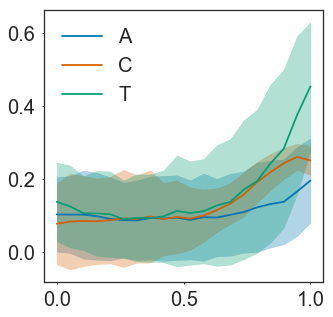

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 20, endpoint=True)
for i, label in enumerate('ACT'):
    ax.plot(x, base_freq_scores[:, i], label=label, color=pal[i])
    ax.fill_between(x,
                    base_freq_scores[:, i] - base_freq_std[:, i],
                    base_freq_scores[:, i] + base_freq_std[:, i],
                    color=pal[i],
                    alpha=0.3)
plt.legend()
plt.show()

In [20]:
with h5py.File('./data/hg38_promoter_g4_paired_mutmaps.h5') as f:
    r = f['intervals/ref_names'].value.tobytes().decode('utf-8')
    s, mat = mm.pairwise_scores_to_sparse_mmap(f, 101)

In [106]:
def get_pairwise_mutmaps(h5_fn):
    with h5py.File(h5_fn) as h5_file:
        refs = (h5_file['intervals/ref_names'].value
                                        .tobytes()
                                        .decode('utf-8')
                                        .split(','))
        start = 0
        for idx in range(h5_file['intervals/ref_ids'].shape[0]):
            inv = (refs[h5_file['intervals/ref_ids'][idx]],
                   h5_file['intervals/start'][idx],
                   h5_file['intervals/end'][idx],
                   h5_file['intervals/reverse'][idx])
            seq_ohe = h5_file['seq'][idx]
            end = start + h5_file['mutmaps/n_points'][idx]
            slic = slice(start, end)
            mut_idx = h5_file['mutmaps/idx'][slic]
            mm_scores = h5_file['mutmaps/scores'][slic]
            actual = mm_scores[0]
            mm_scores = mm_scores[1:] - actual
            mut_idx = mut_idx[1:]
            mat = coo_matrix((mm_scores, (mut_idx[:, 0], mut_idx[:, 1])),
                             shape=(128, 128))
            mat = mat.tocsr()
            start = end
            yield actual, mat, seq_ohe, inv


def symmetrize(mat):
    return mat + mat.T - np.diag(mat.diagonal())


def find_interacting_mutations(pairwise_mm_iter, threshold=0.1):
    for score, mat, seq_ohe, inv in pairwise_mm_iter:
        diag = mat.diagonal()
        for i, j in it.combinations(np.arange(128), r=2):
            if np.abs(mat[i, j]) > np.abs(diag[i] + diag[j]) + threshold:
                yield score, mat, seq_ohe, inv, (i, j)
                break

In [ ]:
mat_iter = get_pairwise_mutmaps('./data/hg38_promoter_g4_paired_mutmaps.h5')
for s, mat, seq_ohe, inv, (i, j) in find_interacting_mutations(mat_iter, 0.5):
    seq = list(decode_ohe(seq_ohe))
    print(inv)
    mat = pd.DataFrame(
        symmetrize(mat.toarray()),
        index=seq,
        columns=seq)
    assert i < j
    mat = mat.iloc[i - 25: j + 25, i - 25: j + 25]
    if mat.size:
        fig, ax = mm.plot_pairwise_mut_map(s, mat)
        ax.plot([0, len(mat)], [0, len(mat)], ls='--', color='#555555')
        ax.set(xlim=(0, len(mat)), ylim=(0, len(mat)))
        plt.show()